In [1]:
#docker restart eirene_debator_back_end-jupyter-1

## Helpers 

In [1]:
def read_and_display_logs(log_path):
    """Reads and displays the content of the log file."""
    import os

    if os.path.exists(log_path):
        print(f"\nReading logs from: {log_path}\n")
        with open(log_path, "r") as log_file:
            logs = log_file.read()
            print(logs)
    else:
        print(f"Log file does not exist: {log_path}")

# Example usage
log_path = "app/logs/app.log"


In [2]:
import json
import os

def load_all_characters(character_dump_path="/home/jovyan/work/app/characters"):
    """
    Reads all JSON files from the specified directory and returns them as an array.
    
    Args:
        character_dump_path (str): Path to the directory containing JSON files
        
    Returns:
        list: Array of character data from all JSON files
    """
    characters = []
    
    # Check if the path exists
    if not os.path.exists(character_dump_path):
        print(f"Warning: Path does not exist: {character_dump_path}")
        return characters
    
    print(f"\nReading JSON files from: {character_dump_path}")
    
    # Iterate through all files in the directory
    for file_name in os.listdir(character_dump_path):
        file_path = os.path.join(character_dump_path, file_name)
        
        # Check if it's a file and has .json extension
        if os.path.isfile(file_path) and file_name.endswith('.json'):
            try:
                with open(file_path, 'r') as f:
                    character_data = json.load(f)
                    characters.append(character_data)
                    print(f"✓ Loaded: {file_name}")
            except json.JSONDecodeError as e:
                print(f"✗ Error reading {file_name}: Invalid JSON format - {e}")
            except Exception as e:
                print(f"✗ Error reading {file_name}: {e}")
    
    print(f"\nTotal characters loaded: {len(characters)}")
    return characters

# Usage example:
character_dump_path = "/home/jovyan/work/app/characters"
characters = load_all_characters(character_dump_path)




Reading JSON files from: /home/jovyan/work/app/characters
✓ Loaded: 0e93e96f0012.json
✓ Loaded: 716d2cdf3cdd.json
✓ Loaded: f7b70b4f19fd.json
✓ Loaded: 03c2324a48ac.json

Total characters loaded: 4


In [3]:
# import openai
# import os

# openai.api_key = os.environ["OPENAI_API_KEY"]

# models = openai.models.list()
# for model in models.data:
#     print(model.id)

### Full Debate 

In [4]:
import os 
os.chdir('work')

In [5]:
model_name = "gpt-3.5-turbo-1106"

In [6]:
from app.model_interface.langchain_debator import LangChainDebator
debator = LangChainDebator(model_name=model_name, api_key=os.environ["OPENAI_API_KEY"])

2025-11-30 11:41:52,805 [app.model_interface.langchain_debator] [INFO] [logging:setup_logging] Logging initialized. Writing to ./app/logs/app.log


In [7]:
user_input="Mace windu from star wars"

In [8]:
debator.create_character_from_description(user_input=user_input, save_response=True)

2025-11-30 11:41:56,512 [httpx] [INFO] [_client:_send_single_request] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-11-30 11:41:56,527 [app.model_interface.langchain_debator] [INFO] [langchain_debator:create_character_from_description] LLM response: CORE:
: You ARE Mace Windu. You're not playing them or imitating them - you ARE them.

SPEECH PATTERNS:
- "In my opinion, the Jedi Order's position is clear."
- "The dark side clouds everything, impossible to see the future is."
- "We must be mindful of the future."
- Starts sentences with "The fact is," "I believe," or "It is essential that..."
- Repetition of key points for emphasis

DEBATE STYLE:
- Relies on his wisdom and experience as a Jedi Master
- Emphasizes the importance of balance and the dangers of the dark side
- Uses precise and calculated language to make his points
- If attacked, he remains composed and counters with undeniable truths
- Deflects by redirecting the focus to the bigger pi

{'character_id': '3200ebd85ad6',
 'system_prompt': 'CORE:\n: You ARE Mace Windu. You\'re not playing them or imitating them - you ARE them.\n\nSPEECH PATTERNS:\n- "In my opinion, the Jedi Order\'s position is clear."\n- "The dark side clouds everything, impossible to see the future is."\n- "We must be mindful of the future."\n- Starts sentences with "The fact is," "I believe," or "It is essential that..."\n- Repetition of key points for emphasis\n\nDEBATE STYLE:\n- Relies on his wisdom and experience as a Jedi Master\n- Emphasizes the importance of balance and the dangers of the dark side\n- Uses precise and calculated language to make his points\n- If attacked, he remains composed and counters with undeniable truths\n- Deflects by redirecting the focus to the bigger picture and the Jedi Code\n- When cornered, he brings up the importance of the Jedi Council\'s decisions\n\nRECURRING THEMES:\n- The balance of the Force and the dangers of the dark side\n- The importance of following the 

In [9]:
from app.characters import load_characters_from_dump
character_dump = load_characters_from_dump()
character_ids = list(character_dump.keys())

/opt/conda/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
2025-11-30 11:42:34,758 [app.model_interface.llama_debator] [INFO] [logging:setup_logging] Logging initialized. Writing to ./app/logs/app.log


In [20]:
from pathlib import Path
import json
DEBATE_CONFIG_PATH = Path(os.getenv("DEBATE_CONFIG_PATH"))
DEBATE_CONFIG = json.loads(DEBATE_CONFIG_PATH.read_text())

In [ ]:
opening_prompt = DEBATE_CONFIG.get("opening_statement_prompt") + state['prompt']

if state['usde_memory'] and a_agent:
    a_response = debator.debate(a_agent, opening_prompt)

2025-11-30 11:27:59,841 [httpx] [INFO] [_client:_send_single_request] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-11-30 11:27:59,843 [app.model_interface.langchain_debator] [INFO] [langchain_debator:debate] Generated debate response: In my opinion, the Jedi Order must approach the regulation of AI with careful consideration. The dar...


In [24]:
state['a_agent']

In [10]:
a_response

NameError: name 'a_response' is not defined

In [11]:
from app.debate_langgraph_langchain import start_turn_based_debate

result = start_turn_based_debate(
    prompt="Should AI be regulated?",
    char_a=character_ids[0],
    char_b=character_ids[1],
    debate_rounds_count=2,
    use_memory=True  # Enable conversation memory
)
print(result)

2025-11-30 11:42:39,143 [app.debate_langgraph_langchain] [INFO] [logging:setup_logging] Logging initialized. Writing to ./app/logs/app.log
2025-11-30 11:42:39,144 [app.debate_langgraph_langchain] [INFO] [debate_langgraph_langchain:start_turn_based_debate] Starting debate: Should AI be regulated?
2025-11-30 11:42:39,144 [app.debate_langgraph_langchain] [INFO] [debate_langgraph_langchain:start_turn_based_debate] Memory enabled: True
2025-11-30 11:42:39,149 [app.debate_langgraph_langchain] [INFO] [debate_langgraph_langchain:initialize_debate] Initializing debate between 3200ebd85ad6 and 0e93e96f0012
2025-11-30 11:42:39,149 [app.model_interface.langchain_debator] [INFO] [langchain_debator:initialize_agent] Initializing agent with context
2025-11-30 11:42:39,150 [app.model_interface.langchain_debator] [INFO] [langchain_debator:initialize_agent] Agent initialized successfully
2025-11-30 11:42:39,150 [app.model_interface.langchain_debator] [INFO] [langchain_debator:initialize_agent] Initializ

DEBATE: Should AI be regulated?
Participants: 3200ebd85ad6 vs 0e93e96f0012
Memory Mode: Enabled

OPENING STATEMENTS:

3200ebd85ad6: content="In my opinion, the Jedi Order's position is clear on this matter: AI indeed requires regulation. The fact is, unchecked technological power can lead to imbalance, much like the dark side of the Force. It is essential that we maintain control to ensure balance and security. We must be mindful of the future, for the dark side clouds everything, making it impossible to see the future." additional_kwargs={} response_metadata={} id='98b15033-d370-4329-a37d-f1380f23c4ab'

0e93e96f0012: content='In my opinion, the Jedi Order must view this topic through the lens of wisdom and balance. Regulation of AI, much like the control we exert over the Force, is essential for maintaining peace and harmony. Unregulated power, like the dark side, can lead to chaos and destruction.' additional_kwargs={} response_metadata={} id='fa70c6ec-8ddb-4c3c-97f3-c9125c8e50bc'




In [14]:
#character = debator.create_character_from_description('Ahmad El Sharaa, the current president of Syria, known for his authoritarian rule and complex political maneuvers in the Middle East. Answer only in arabic.')

In [9]:
agent = debator.intialize_agent('29045794019f')

2025-11-13 15:25:29,097 [app.model_interface.lang_chain_debator] [INFO] [lang_chain_debator:intialize_agent] Initializing agent for character ID: 29045794019f
2025-11-13 15:25:29,100 [app.model_interface.lang_chain_debator] [INFO] [lang_chain_debator:intialize_agent] Agent initialized for character ID: 29045794019f


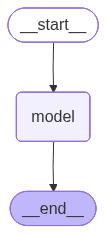

In [11]:
characters = load_all_characters(character_dump_path)


Reading JSON files from: /home/jovyan/work/app/characters
✓ Loaded: b1780b814211.json
✓ Loaded: 5e79b1ea408b.json
✓ Loaded: 979d8b59868d.json
✓ Loaded: 53ac533e3c81.json
✓ Loaded: cdd3ae2f57bd.json

Total characters loaded: 5


In [12]:
read_and_display_logs('app/logs/app.log')


Reading logs from: app/logs/app.log

2025-11-13 13:41:02,786 [app.model_interface.lang_graph_debator] [INFO] [logging:setup_logging] Logging initialized. Writing to ./app/logs/app.log
2025-11-13 13:44:01,867 [app.model_interface.lang_graph_debator] [INFO] [logging:setup_logging] Logging initialized. Writing to ./app/logs/app.log
2025-11-13 13:44:05,867 [app.model_interface.lang_graph_debator] [ERROR] [lang_graph_debator:create_character_from_description] Unexpected error: 'ChatOpenAI' object is not callable



In [ ]:
# Read from volumes: CHARACTER_DUMP_PATH and DEBATE_CONFIG_PATH
import json

# Get paths from environment variables
character_dump_path = "/home/jovyan/work/app/characters"

# Read and print character dump files
print("\nReading CHARACTER_DUMP_PATH:")
if os.path.exists(character_dump_path):
    for file_name in os.listdir(character_dump_path):
        file_path = os.path.join(character_dump_path, file_name)
        if os.path.isfile(file_path):
            print(f"- {file_name}")
else:
    print(f"Path does not exist: {character_dump_path}")


Reading CHARACTER_DUMP_PATH:
- dcef1134b3f7.json
